# Прогонзирование необходимого бюджета для достижения экономических показателей регионов РК

В этом блокноте мы тренируем модель [MLP](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#regression) для регрессионной задачи.

Для входящих инпутов мы выбрали три экономических параметра региона, на которые влияет объем бюджетных инвестиций:
- [ВРП](https://ru.wikipedia.org/wiki/%D0%92%D0%B0%D0%BB%D0%BE%D0%B2%D0%BE%D0%B9_%D1%80%D0%B5%D0%B3%D0%B8%D0%BE%D0%BD%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9_%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%82)
- Налоговые поступления в регион
- Среднемесячная зарплата в регионе

## Сбор данных

Для сбора данных мы использовали открытые источники [Министерства Финансов Республики Казахстан](https://www.gov.kz/memleket/entities/minfin?lang=ru) и [Бюро национальной статистики Агентства по стратегическому планированию и реформам Республики Казахстан](https://stat.gov.kz).

Из статистических бюллетеней МФ РК мы взяли **поступления трансфертов** и **налоговых поступлений**, из ИФО мы взяли ВРП регионов за период с 2008 по 2021 года.

Таблица с данными находится в файле `data1.csv`

Импортируем данные из csv в DataFrame при помощи модуля [pandas](https://pandas.pydata.org/), после чего сортируем их по выбранному региону

In [339]:
import pandas as pd

df = pd.read_csv('data1.csv', delimiter=";", parse_dates=['год'], decimal=',')
# df = df.iloc[::-1]

train_on_all_regions = False

model_type = "LR" # NN | LR

load_saved = False

# Регион можно менять
chosen_region = "Акмолинская"

region_df = df[df['область'] == chosen_region]

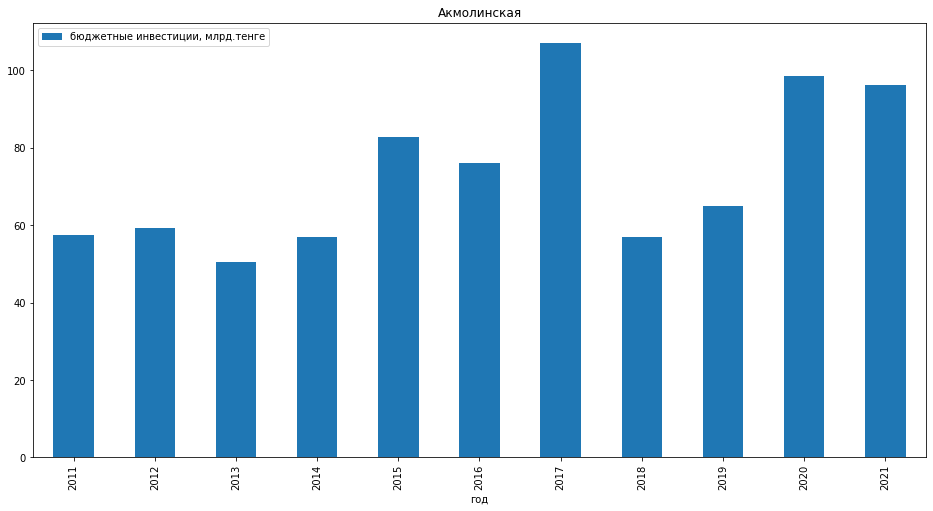

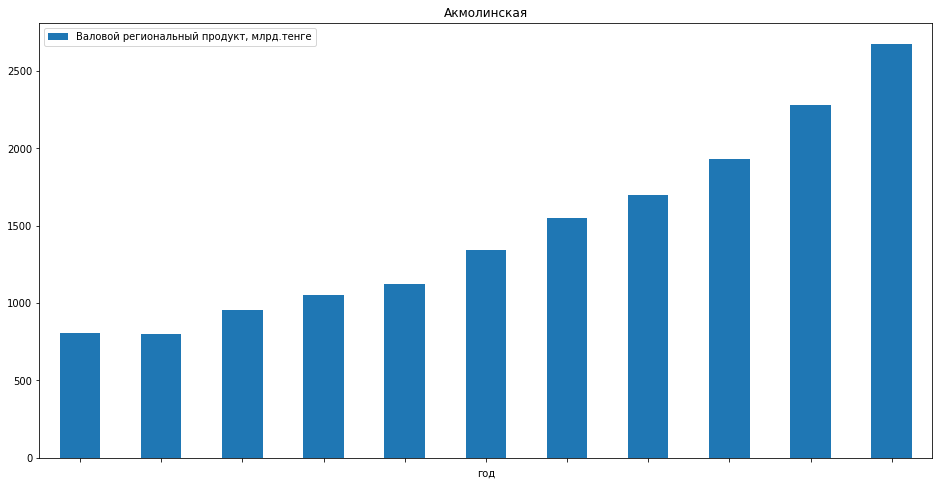

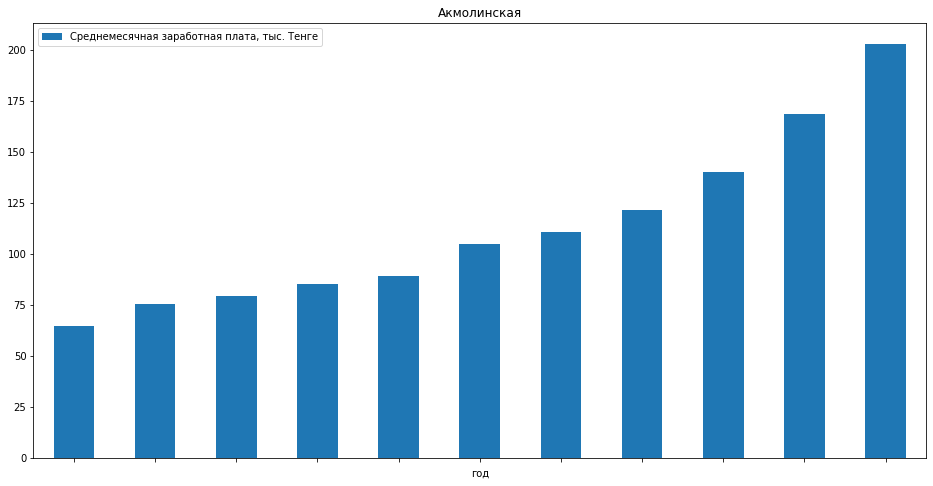

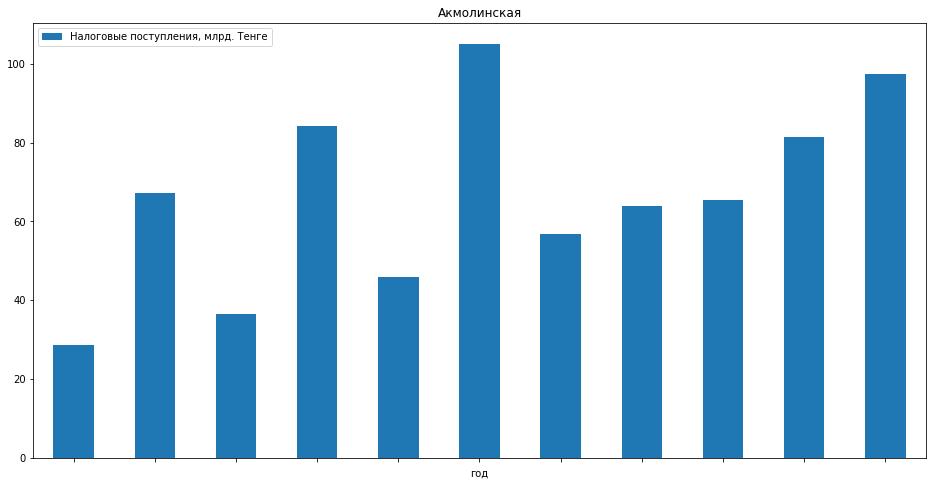

In [340]:
y_label = 'бюджетные инвестиции, млрд.тенге'
y_idx = 2

x1_label = 'Валовой региональный продукт, млрд.тенге'
x1_idx = 5
x2_label = 'Среднемесячная заработная плата, тыс. Тенге'
x2_idx = 6
x3_label = 'Налоговые поступления, млрд. Тенге'
x3_idx = 8
x4_label = 'Текущие целевые трансферты, млрд.тенге'
x4_idx = 9

x_labels = map(lambda label: label.year, region_df['год'])
plt1 = region_df.plot(x='год', y=y_label, kind='bar', title=chosen_region, figsize=(16, 8))
plt1.set_xticklabels(x_labels)
plt1.legend([y_label], loc="upper left")

plt2 = region_df.plot(x='год', y=x1_label, kind='bar', label="ВРП", title=chosen_region,
                      figsize=(16, 8))
plt2.set_xticklabels(x_labels)
plt2.legend([x1_label], loc="upper left")

plt2 = region_df.plot(x='год', y=x2_label, kind='bar', label="ВРП", title=chosen_region,
                      figsize=(16, 8))
plt2.set_xticklabels(x_labels)
plt2.legend([x2_label], loc="upper left")

plt3 = region_df.plot(x='год', y=x3_label, kind='bar', label="ВРП", title=chosen_region,
                      figsize=(16, 8))
plt3.set_xticklabels(x_labels)
plt3.legend([x3_label], loc="upper left")

Форматируем переменные в формат подходящий для тренировки модели

In [341]:
import numpy as np

np.random.seed(0)

if not train_on_all_regions:
    df = region_df

X = df.iloc[:, [x1_idx, x2_idx, x3_idx, x4_idx]].values
X = X.astype('float32')
y = df.iloc[:, y_idx].values

print(X)

print(y)

[[ 804.7   64.4   28.5   13.6]
 [ 799.9   75.6   67.1   19.1]
 [ 955.6   79.1   36.4   36.1]
 [1051.    85.4   84.2   29.9]
 [1121.    89.1   45.9   34.4]
 [1344.3  104.8  105.1   70.1]
 [1552.7  110.7   56.9   26.2]
 [1699.8  121.3   63.8   22.1]
 [1933.5  140.2   65.5   58.1]
 [2284.   168.3   81.4   73.7]
 [2678.   203.    97.3   89.2]]
[ 57.5  59.2  50.6  56.9  82.9  76.1 107.   56.9  64.9  98.5  96.2]


Для тренировки, мы разбиваем наборы данных на тренировочные и тестовые:
- 80 процентов данных будут использоваться для тренировки
- 20 процентов данных будут использоваться для тестирования

In [342]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Наша задача состоит в предсказании числового значения в определенном промежутке, что попадает под категорию [регресии](https://ru.wikipedia.org/wiki/%D0%A0%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F_(%D0%BC%D0%B0%D1%82%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D0%BA%D0%B0))

В качестве модели мы используем [MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor), так как он показал наибольшую точность по сравнению с:
- LinearRegression
- SVR
- SGDRegressor
- KNeighborsRegressor
- BayesianRidge
- TheilSenRegressor

Архитектура нейронной сети будет состоять из:
- 3 входящих нейронов
- 100 скрытых нейронов
- 1 выходного нейрона

Так как данных не настолько много, мы используем функцию активации [tanh](https://en.wikipedia.org/wiki/Hyperbolic_functions#Hyperbolic_tangent) и алгоритм обучения [lbfgs](https://en.wikipedia.org/wiki/Limited-memory_BFGS)

In [343]:
# MLP model
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

from joblib import load

import tensorflow as tf
import pandas as pd

region = "all-regions" if train_on_all_regions else chosen_region

if load_saved:
    if model_type == "LR":
        regressor = load(f'models/lr-{region}.joblib')
    elif model_type == "NN":
        regressor = tf.keras.models.load_model( f'models/nn-{region}')
else:
    if model_type == "NN":
        regressor = tf.keras.models.Sequential()
        regressor.add(tf.keras.layers.LSTM(200, input_shape=(3, 1), activation='tanh'))
        regressor.add(tf.keras.layers.Dense(1))
        regressor.compile(loss='mean_absolute_error', optimizer='adam')

        regressor.fit(X_train, y_train, epochs=1000, batch_size=16)
    elif model_type == "LR":
        regressor = make_pipeline(
            StandardScaler(),
            MLPRegressor(
                random_state=1,
                max_iter=int(1e6),
                max_fun=int(1e5),
                activation="tanh",
                solver="lbfgs",
                tol=1e-5,
            )
        )
        regressor.fit(X_train, y_train)

In [344]:
y_pred = regressor.predict(X_test)

Подсчитываем точность модели в величину ошибок:
- Среднюю абсолютную ошибку [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error)
- Среднюю абсолютную ошибку в процентах[MAPE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html#sklearn.metrics.mean_absolute_percentage_error)
- Максимальная ошибка [Max Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.max_error.html#sklearn.metrics.max_error)

In [345]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Absolute Percentage Error:', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('Max Error:', metrics.max_error(y_test, y_pred))

Mean Absolute Error: 30.603483288578172
Mean Absolute Percentage Error: 0.47355206758308155
Max Error: 45.630736121705915


Подготоваливаем графики для показа предсказаний за года с 2011 по 2021

In [346]:
X = region_df.iloc[:, [x1_idx, x2_idx, x3_idx, x4_idx]].values
X = X.astype('float32')
y = region_df.iloc[:, y_idx].values

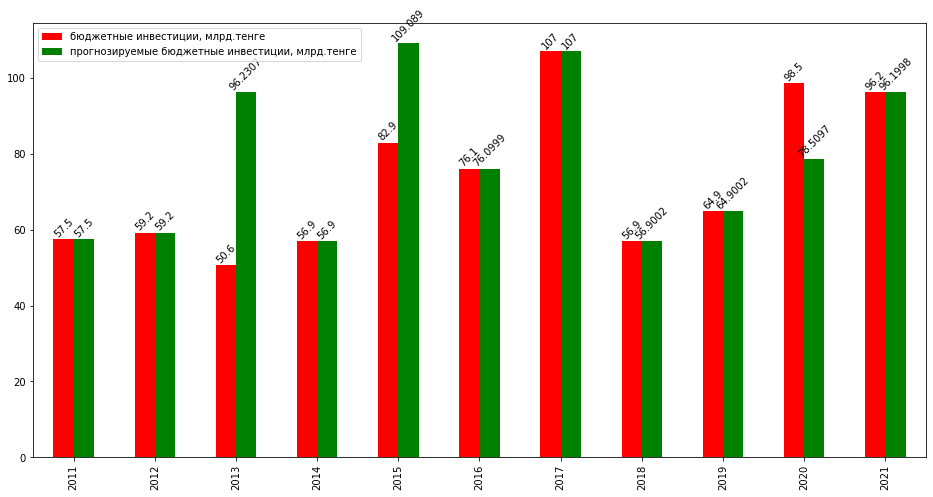

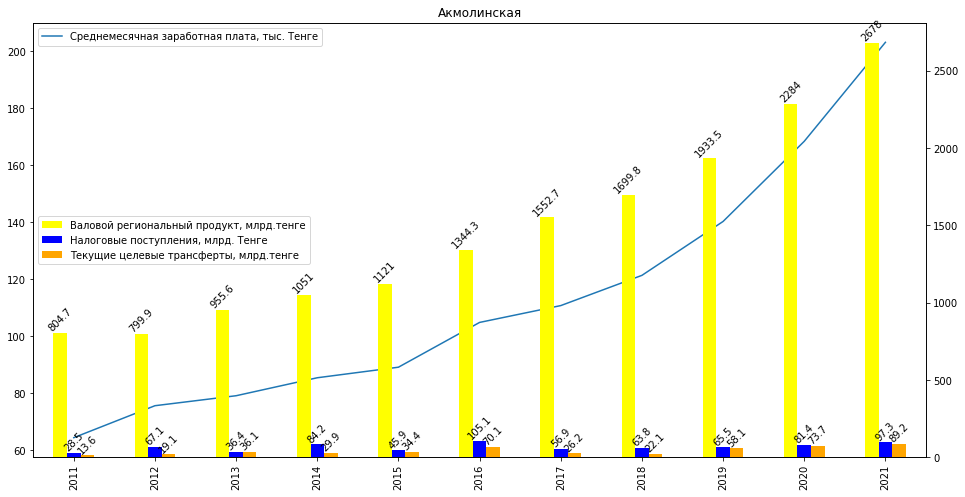

In [352]:
result_df = pd.DataFrame()

y_hat_label = 'прогнозируемые бюджетные инвестиции, млрд.тенге'

result_df['год'] = region_df['год']
result_df[y_label] = y
result_df[y_hat_label] = regressor.predict(X)
result_df[x1_label] = region_df[x1_label]
result_df[x2_label] = region_df[x2_label]
result_df[x3_label] = region_df[x3_label]
result_df[x4_label] = region_df[x4_label]
result_df.set_index('год', inplace=True)

ax = result_df[[y_label, y_hat_label]].plot(
    figsize=(16, 8),
    kind="bar",
    use_index=False,
    color=['red',
           'green'])

x_labels = result_df.index.strftime('%Y')
ax.set_xticklabels(x_labels)

ax.legend([y_label, y_hat_label], loc="upper left")
for bars in ax.containers:
    ax.bar_label(bars, rotation=45)

ax1 = result_df[[x2_label]].plot(figsize=(16, 8), title=chosen_region,
                                 use_index=False)
ax2 = result_df[[x1_label, x3_label, x4_label]].plot(ax=ax1,
                                           kind="bar",
                                           secondary_y=True,
                                           use_index=False,
                                           color=[
                                               'yellow', 'blue', 'orange'])
ax1.set_xticklabels(x_labels)

ax1.legend([x2_label], loc="upper left")
ax2.legend(
    [x1_label, x3_label, x4_label],
    loc="center left")

for bars in ax2.containers:
    ax2.bar_label(bars, rotation=45)

Для проверки модели на реальных данных мы взяли информацию за 2021 по Акмолинской области.

Текущие показатели (2022 март):
- Сумма трансфертов 32 959 млн тенге
- ВРП 103.3 процента
- Налоговые перечисления 18 062 млн тенге

Модель показывает, что при данных показателях ВРП и доходов, региону требовалось только 14 569 млн тенге, что составляет только 45% от реально перечисленных средств.

[97.18522239]


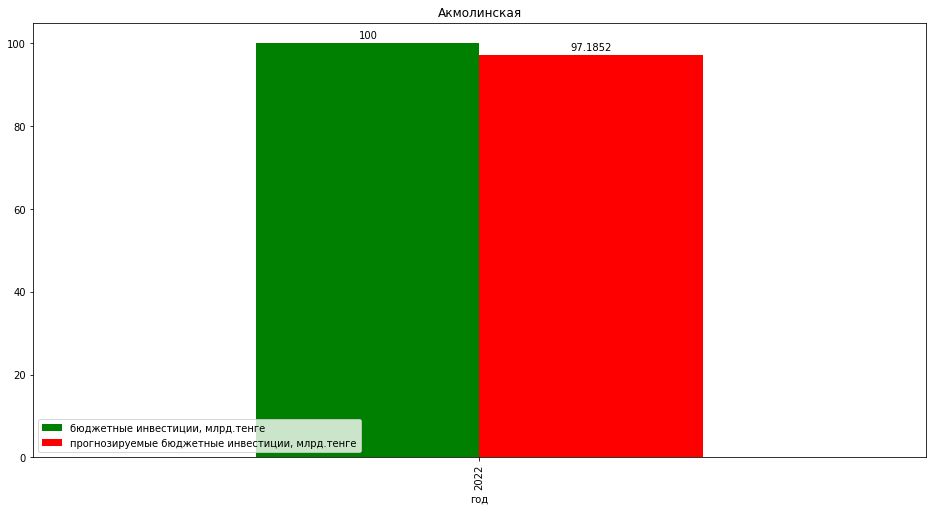

In [348]:
result_test_df = pd.DataFrame()

x1_test = 2785.12
x2_test = 210
x3_test = 98
x4_test = 93.66

X_test = [[x1_test, x2_test, x3_test, x4_test]]

Pred_Budget = regressor.predict(X_test)

y_real = 100

result_test_df['год'] = [2022]
result_test_df['бюджетные инвестиции, млрд.тенге'] = [y_real]
result_test_df['прогнозируемые бюджетные инвестиции, млрд.тенге'] = Pred_Budget
result_test_df.set_index('год', inplace=True)

print(Pred_Budget)

ax1 = result_test_df[['бюджетные инвестиции, млрд.тенге', 'прогнозируемые бюджетные инвестиции, млрд.тенге']].plot(
    kind="bar", color=['green', 'red'], figsize=(16, 8),
    title=chosen_region)
ax1.legend(['бюджетные инвестиции, млрд.тенге', 'прогнозируемые бюджетные инвестиции, млрд.тенге'],
           loc="lower left")

for container in ax1.containers:
    ax1.bar_label(container, padding=3)

Сохраняем модель для дальнейшего использования

In [349]:
from joblib import dump

region = "all-regions" if train_on_all_regions else chosen_region

if model_type == "LR":
    dump(regressor, f'models/lr-{region}.joblib')
elif model_type == "NN":
    tf.keras.models.save_model(regressor, f'models/nn-{region}')